In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('./../../')  
from src.signals.BaseSignal import BaseSignal, TimeSignal
from scipy.signal import find_peaks
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed


In [2]:
FS = 125

info = pd.read_csv("dataset_info.csv")

In [191]:
class MultiSignal:
    def __init__(self, name, abp, ppg, ecg):
        self.abp = abp
        self.ppg = ppg
        self.ecg = ecg
        self.duration = self.ecg.duration
        self.signals = [self.abp, self.ppg, self.ecg]
        
    def plot(self, start=0, width=10, scatter=False, line=True, first_der=False):
        fig, axes = plt.subplots(3, 1, figsize=(24, 15))
        for signal, ax in zip(self.signals, axes):
            signal.plot(start, width, scatter, line, first_der, ax=ax)
        plt.tight_layout()

def create_multisignal(path, fs=FS):
    sample = pd.read_csv(path)
    abp = BaseSignal("ABP", sample.ABP.values, fs)
    ppg = BaseSignal("PPG", sample.PPG.values, fs)
    ecg = BaseSignal("ECG", sample.ECG.values, fs)
    return MultiSignal(path, abp, ppg, ecg)

def find_closest(arr, el):
    return arr[abs(arr - el).argmin()]

def find_sbp_peaks(abp):
    filtered_abp = abp.get_fir_filtered(cutoff=3, btype='lowpass', numtaps=30)
    mean_data_val = abp.data.mean() + abp.data.std() / 4
    abp_peaks, _ = find_peaks(abp.data)
    filtered_abp_peaks, _ = find_peaks(filtered_abp.data)

    final_peaks = []
    for peak in filtered_abp_peaks:
        closest_peak = find_closest(abp_peaks, peak)
        closest_peak_val = abp.data[closest_peak]
        if closest_peak_val > mean_data_val:
            final_peaks.append(closest_peak)
    final_peaks = np.array(final_peaks)
    
    return final_peaks

def find_dbp_troughs(abp, peaks):
    n_neighbours = 30
    filtered_abp = abp.get_fir_filtered(cutoff=2, btype='lowpass', numtaps=35)
    mean_data_val = abp.data.mean()
    abp_troughs, _ = find_peaks(-abp.data)
    filtered_abp_troughs, _ = find_peaks(-filtered_abp.data)

    final_troughs = []
    for trough in filtered_abp_troughs:
        closest_trough = find_closest(abp_troughs, trough)
        closest_trough_val = abp.data[closest_trough]
        if closest_trough_val < mean_data_val:
            left_bound = 0 if n_neighbours > closest_trough else closest_trough - n_neighbours
            right_bound = len(abp.data) if closest_trough + n_neighbours > len(abp.data) else closest_trough + n_neighbours
            neighborhood = abp.data[left_bound : right_bound]
            best_choice = neighborhood.argmin() + left_bound
            if best_choice not in abp_troughs:
                best_choice = closest_trough
            if len(final_troughs) == 0:
                final_troughs.append(best_choice)
            else:
                peaks_diff = peaks - best_choice
                n_prev_peaks = peaks_diff[peaks_diff < 0].sum()
                if n_prev_peaks == 0:
                    final_troughs[-1] = best_choice
                else:
                    prev_peak = peaks[peaks_diff[peaks_diff < 0].argmax()]
                    prev_trough = final_troughs[-1]
                    prev_trough_val = abp.data[prev_trough]
                    current_trough_val = abp.data[best_choice]
                    if prev_trough > prev_peak:
                        if prev_trough_val >= current_trough_val:
                            final_troughs[-1] = best_choice
                    else:
                        final_troughs.append(best_choice)
    final_troughs = np.array(final_troughs)
    return final_troughs

def get_bp_ground_truth(abp, aggregate=True):
    abp_peaks = find_sbp_peaks(abp)
    abp_troughs = find_dbp_troughs(abp, abp_peaks)
    if aggregate:
        SBP = np.mean(abp.data[abp_peaks])
        DBP = np.mean(abp.data[abp_troughs])
    else:
        SBP = TimeSignal("SBP", abp.time[abp_peaks], abp.data[abp_peaks])
        DBP = TimeSignal("DBP", abp.time[abp_troughs], abp.data[abp_troughs])
    return SBP, DBP

In [236]:
def split_samples(info, new_sample_len):
    
    def split_sample(i, start_sec, sample, df):
        fs, subject, start_idx, end_idx, recording, sample_num = sample[['fs', 'subject', 'sample_start_idx', 'sample_end_idx', 'recording', 'sample_num']]
        duration = (end_idx - start_idx) / fs
        end_sec = start_sec + new_sample_len
        if end_sec <= duration:
            try:
                sample_start_idx = start_idx + i * new_sample_len * fs
                df_slice = df.loc[start_sec:end_sec]
                abp = BaseSignal("ABP", df_slice.ABP.values, fs)
                SBP, DBP = get_bp_ground_truth(abp)
                path = Path(f"mimic_csv_{new_sample_len}s/{subject}")
                path.mkdir(parents=True, exist_ok=True)
                df_slice.to_csv(f"{str(path)}/{sample_num}_{i}.csv", index=False)
                with open(f"info_{new_sample_len}s.txt", "a") as file:
                    sample_end_idx = int(sample_start_idx + (end_sec - start_sec) * fs)
                    file.write(f"{subject}_{sample_num}_{i},mimic_db/{recording}/{sample_start_idx}-{sample_end_idx},{SBP},{DBP}\n")
                with open("logs.txt", "a") as file:
                    file.write(f"{subject}_{sample_num}_{i}  OK\n")
                return True
            except Exception as e:
                with open("logs.txt", "a") as file:
                    file.write(f"{subject}_{sample_num}_{i}  failed\n")
                with open(f"info_{new_sample_len}s.txt", "a") as file:
                    sample_end_idx = int(sample_start_idx + (end_sec - start_sec) * fs)
                    file.write(f"{subject}_{sample_num}_{i},mimic_db/{recording}/{sample_start_idx}-{sample_end_idx},-1,-1\n")
        else:
            return False
    
    open(f'info_{new_sample_len}s.txt', 'w').close()

    with open(f"info_{new_sample_len}s.txt", "a") as file:
        file.write("sample,segment,SBP,DBP\n")
        
    for sample in tqdm(info.iterrows(), desc="Iterating over 120s len samples", total=len(info)):
        sample = sample[1]
        fs, start_idx, end_idx = sample[['fs', 'sample_start_idx', 'sample_end_idx']]
        df = pd.read_csv(f"mimic_csv_120s/{sample['sample_path']}")
        df.index = np.arange(0, len(df)) / fs
        duration = (end_idx - start_idx) / fs
        split_samples = Parallel(n_jobs=10)(delayed(split_sample)(i, start_sec, sample, df) for i, start_sec in enumerate(np.arange(0, duration, new_sample_len)))
        
def create_info_csv(segmentation_info, filename):
    fs = np.array([FS]*len(segmentation_info))
    samples_path = np.array([f"{sample}.csv" for sample in segmentation_info['sample']])
    subjects = np.array([sample.split("_")[0] for sample in segmentation_info['sample']])
    subjects_sample_number = np.array([int(sample.split("_")[1]) for sample in segmentation_info['sample']])
    subjects_sample_split_number = np.array([int(sample.split("_")[2]) for sample in segmentation_info['sample']])

    recording_path = np.array(["/".join(segment_path.split("/")[1:-1]) for segment_path in segmentation_info['segment']])
    samples_start_idxs = np.array([int(sample.split("/")[-1].split("-")[0]) for sample in segmentation_info['segment']])
    samples_end_idxs = np.array([int(sample.split("/")[-1].split("-")[1]) for sample in segmentation_info['segment']])
    sbp_values = segmentation_info.SBP.values
    dbp_values = segmentation_info.DBP.values

    dataset_info = pd.DataFrame({
        "sample_path": samples_path,
        "subject": subjects,
        "sample_num": subjects_sample_number,
        "split_num": subjects_sample_split_number,
        "recording": recording_path,
        "sample_start_idx": samples_start_idxs,
        "sample_end_idx": samples_end_idxs,
        "fs": fs,
        "SBP": sbp_values,
        "DBP": dbp_values
    }).sort_values(["subject", "sample_num"]).reset_index(drop=True)
    dataset_info.to_csv(filename, index=False)

In [237]:
split_samples(info, 5)

Iterating over 120s len samples:   0%|          | 0/28537 [00:00<?, ?it/s]

In [238]:
seg_info = pd.read_csv("info_5s.txt")
create_info_csv(seg_info, "dataset_info_5s.csv")

In [253]:
dataset_info_5s = pd.read_csv("dataset_info_5s.csv")
dataset_info_5s = dataset_info_5s.query("50 < SBP < 220 and 30 < DBP < 180").reset_index(drop=True)

<AxesSubplot:xlabel='SBP', ylabel='Density'>

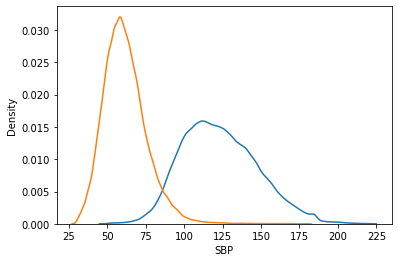

In [254]:
sns.kdeplot(dataset_info_5s['SBP'])
sns.kdeplot(dataset_info_5s['DBP'])

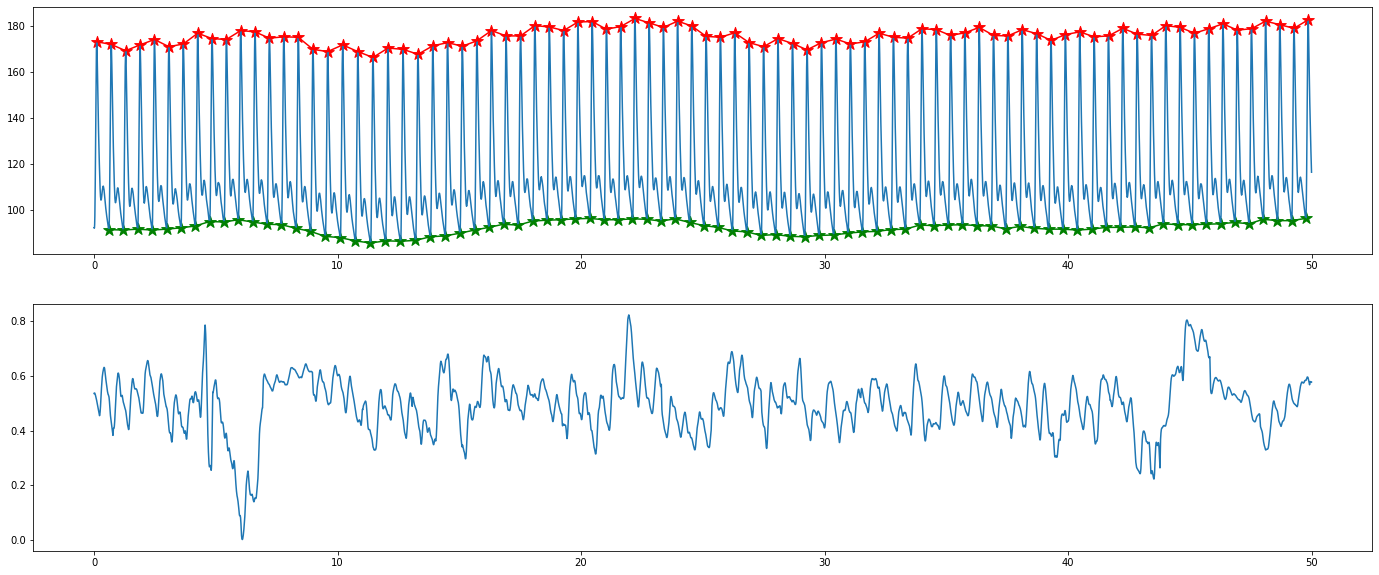

In [217]:

sample_path = info.iloc[99]['sample_path']
sample_path = f"mimic_csv_120s/{sample_path}"
multi_signal = create_multisignal(sample_path)

s, e = 0, 50

abp = multi_signal.abp.get_slice(s, e)
ppg = multi_signal.ppg.get_slice(s, e)
ppg_filt = ppg.get_fir_filtered((1/3, 6), btype='bandpass')

abp_peaks = find_sbp_peaks(abp)
abp_troughs = find_dbp_troughs(abp, abp_peaks)

sbp = TimeSignal("SBP", abp.time[abp_peaks], abp.data[abp_peaks])
dbp = TimeSignal("DBP", abp.time[abp_troughs], abp.data[abp_troughs])

low_thr = np.mean(abp.data) - abp.data.std()
high_thr = np.mean(abp.data) + abp.data.std()

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(24, 10))
filtered_abp = abp.get_fir_filtered(cutoff=3, btype='lowpass', numtaps=30)
ax.plot(abp.time, abp.data)
# filtered_abp.plot(s, e, ax=ax)
ax.scatter(abp.time[abp_peaks], abp.data[abp_peaks], marker='*', s=150, c='r')
ax.scatter(abp.time[abp_troughs], abp.data[abp_troughs], marker='*', s=150, c='g')
ax.plot(sbp.time, sbp.data, c='r')
ax.plot(dbp.time, dbp.data, c='g')

ax2.plot(ppg.time, ppg.data)
# ax2.plot(ppg_filt.time, ppg_filt.data)

In [232]:
from scipy.signal import hamming

def calculate_snr(sig, fs=30.0, hr_bpm=None):
    sig = hamming(len(sig)) * sig
    f_min = 40 / 60
    f_max = 240 / 60
    freqs = np.fft.rfftfreq(len(sig), 1 / fs)
    fft = np.abs(np.fft.rfft(sig)) ** 2

    if hr_bpm is None:
        hr_bpm = 60 * freqs[np.argmax(fft)]
    harmonic_bpm = hr_bpm * 2

    freq_bin = freqs[1] - freqs[0]
    first_min = (hr_bpm - 12) / 60
    if first_min not in freqs:
        first_min -= freq_bin
    first_max = (hr_bpm + 12) / 60
    second_min = (harmonic_bpm - 24) / 60
    if second_min not in freqs:
        second_min -= freq_bin
    second_max = (harmonic_bpm + 24) / 60

    heartband = (
        (freqs >= f_min)
        & (freqs <= f_max)
        & (
            (freqs >= first_min) & (freqs <= first_max)
            | (freqs >= second_min) & (freqs <= second_max)
        )
    )
    noise = (freqs > f_min) & (freqs < f_max) & (~heartband)

    signal_power = np.sum(fft[heartband])
    noise_power = np.sum(fft[noise])
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [233]:
ppg.data

array([0.53567937, 0.53763441, 0.53763441, ..., 0.57673509, 0.57673509,
       0.57771261])

[2.83776892e+06 5.32942606e+05 3.85614453e+02 ... 1.94348037e-04
 6.41402617e-04 3.79821942e-05]


/tmp/ipykernel_9020/926846572.py:38: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


-inf

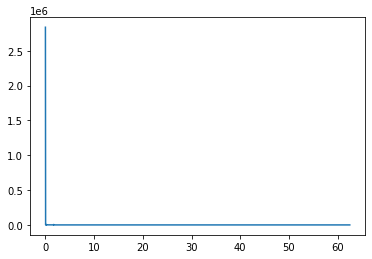

In [234]:
calculate_snr(ppg.data, ppg.fs)

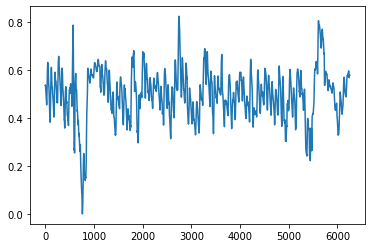

In [219]:
plt.plot(ppg.data)